In [1]:
import os
import sys
sys.path.append('..')  
import random
import pickle

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from sklearn.metrics import roc_curve, auc
from scipy.stats import zscore
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from sklearn.preprocessing import scale
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [5]:
from scregat.data_process import prepare_model_input, sum_counts, plot_edge, ATACGraphDataset
from run_scReGAT import *

/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [6]:
# load graph

In [7]:
with open('../data/dataset_atac_core_MFG.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [8]:
dataset_atac.list_graph[0]

Data(x=[61528, 1], edge_index=[2, 69180], y=[1], edge_tf=[4036, 2], y_exp=[1348], cell='TCCATACCAATGATGCGGCATTCT')

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [10]:
seed = 4446

In [11]:
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
model = SCReGAT()

In [13]:
cells = dataset_atac.adata.obs_names.values

In [14]:
test_cell = random.sample(list(cells),int(len(cells) *0.5))

In [15]:
num_epoch = 4
leanring_rate = 1e-4

In [16]:
balanced_train_graph, test_graph = preprocess_graph(dataset_atac, test_cell, max_random_sample=0, seed=seed, if_test=False,is_balances=False)

Preprocess Start!


Processing samples: 100%|██████████| 2130/2130 [00:00<00:00, 36153.26it/s]


train_graph: 1065
test_graph: 1065
random max_values: 5.2995219230651855


Processing samples: 0it [00:00, ?it/s]

adding random nodes...: 0


In [17]:
model = train_model(model, balanced_train_graph, num_epoch=num_epoch, batch_size=15, lr=leanring_rate, max_grad_norm=1.0, sparse_loss_weight=0.1,
                    if_zero=False,use_device=device)

Epoch 1/4: 100%|██████████| 71/71 [00:23<00:00,  3.00batch/s, loss=1.28, loss1=1.01, sparse_loss=0.269]


Epoch [1/4], Average Loss: 1.2821, Loss1: 1.0126, Sparse Loss: 0.2695


Epoch 2/4: 100%|██████████| 71/71 [00:21<00:00,  3.24batch/s, loss=0.284, loss1=0.015, sparse_loss=0.269] 


Epoch [2/4], Average Loss: 0.2838, Loss1: 0.0150, Sparse Loss: 0.2688


Epoch 3/4: 100%|██████████| 71/71 [00:21<00:00,  3.23batch/s, loss=0.271, loss1=0.00284, sparse_loss=0.268]


Epoch [3/4], Average Loss: 0.2707, Loss1: 0.0028, Sparse Loss: 0.2679


Epoch 4/4: 100%|██████████| 71/71 [00:21<00:00,  3.27batch/s, loss=0.268, loss1=0.00111, sparse_loss=0.267]

Epoch [4/4], Average Loss: 0.2683, Loss1: 0.0011, Sparse Loss: 0.2672


In [18]:
res_edge, test_barcodes = test_model(dataset_atac, model, test_graph, batch_size=20, device=device, if_test=False)

Processing Batches: 100%|██████████| 54/54 [00:07<00:00,  7.04it/s]


In [19]:
# save h5ad

In [20]:
adata_edge = ad.AnnData(X=res_edge, obs=dataset_atac.adata.obs.loc[test_barcodes,])

In [21]:
adata_edge

AnnData object with n_obs × n_vars = 1065 × 69180
    obs: 'celltype', 'celltype_rna', 'nb_features'

In [22]:
edge_info = get_edge_info(dataset_atac)
edge_info['edge'] = edge_info['peak'] + "_" + edge_info['gene']

In [23]:
adata_edge.var_names = edge_info.edge.values

#### Silhouette Coefficient

In [24]:
# load data

In [25]:
with open('../data/dataset_atac_core_MFG.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [26]:
adata_edge = sc.read_h5ad("../data/scRP_MFG.h5ad")
adata_edge

AnnData object with n_obs × n_vars = 1065 × 69180
    obs: 'celltype', 'celltype_rna', 'nb_features'

In [27]:
adata = adata_edge.copy()

# Normalize, log-transform, and select highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]

# Scale and reduce dimensions with PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)

In [28]:
# Calculate silhouette score on PCA space
score = silhouette_score(adata.obsm['X_pca'], adata.obs['celltype'], metric='cosine')
print('Silhouette Coefficient:', score)

Silhouette Coefficient: 0.6502173


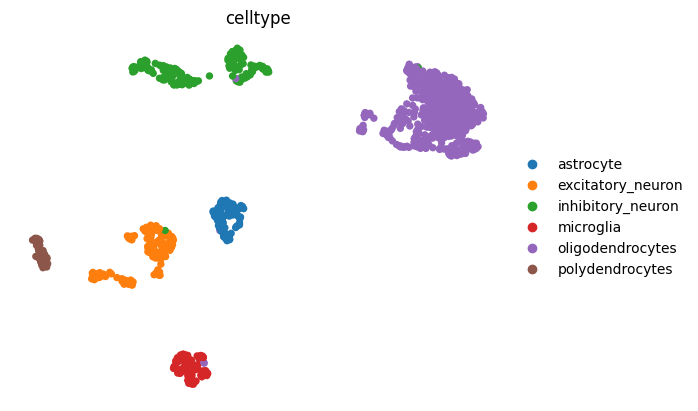

In [29]:
# Compute neighbors and UMAP embedding
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric='cosine')
sc.tl.umap(adata, min_dist=0.5)

# Visualize UMAP by cell type
sc.pl.umap(adata, color='celltype', wspace=0.5, frameon=False)

### cell-type-specific  cRE interactions

In [30]:
cell_type_cpu = dataset_atac.adata.obs.loc[adata_edge.obs_names]['celltype'].values
cell_type_cpu = np.array(cell_type_cpu)
cell_type_cpu[[idx for idx,t in enumerate(cell_type_cpu) if t.startswith('excitatory_neuron')]] = 'neurons'
cell_type_cpu[[idx for idx,t in enumerate(cell_type_cpu) if t.startswith('inhibitory_neuron')]] = 'neurons'
unique_celltype = list(np.unique(cell_type_cpu))

In [31]:
celltype = ["microglia","neurons","oligodendrocytes"]
edge_names_path_list = [ "../data/celltype_specific_cRE_interactions/" + t + "_specific.bed"
                        for t in celltype]
edge_names_path_list

['../data/celltype_specific_cRE_interactions/microglia_specific.bed',
 '../data/celltype_specific_cRE_interactions/neurons_specific.bed',
 '../data/celltype_specific_cRE_interactions/oligodendrocytes_specific.bed']

In [32]:
res_edge = adata_edge.X

In [33]:
def plot_regulatory_scores(res_edge, edge_index, cell_types, unique_types, title="Regulatory Scores"):
    # Normalize scores
    scores = zscore(res_edge[:, edge_index], axis=0)

    # Calculate mean values per cell type
    means = [scores[cell_types == ct].mean(axis=0) for ct in unique_types]
    medians = [np.median(m) for m in means]

    # Sort by median
    sorted_idx = np.argsort(medians)[::-1]
    sorted_types = [unique_types[i] for i in sorted_idx]
    sorted_means = [means[i] for i in sorted_idx]

    # Prepare DataFrame
    df = pd.DataFrame({
        'Group': np.repeat(sorted_types, [len(m) for m in sorted_means]),
        'Values': np.concatenate(sorted_means)
    })

    # Clip scores to [-1, 1] range (like R code)
    df['Values'] = df['Values'].clip(-1, 1)

    # Statistical test (Mann-Whitney U)
    top_group = sorted_types[0]
    pvals = [1.0 if ct == top_group else ranksums(
        df[df['Group'] == top_group]['Values'],
        df[df['Group'] == ct]['Values']
    )[1] for ct in sorted_types]
    _, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')

    # Plot
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Group', y='Values', data=df, order=sorted_types,
                palette='tab10', linewidth=0.8, whis=1.5, showfliers=False)
    
    plt.title(title, fontsize=10, fontweight='bold')
    plt.ylabel("Regulatory score", fontsize=9)
    plt.xlabel("Cell Type", fontsize=9)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(-1.1, 1.1 )
    sns.despine()

    # Annotate p-values
    for i, p in enumerate(adj_pvals):
        if sorted_types[i] != top_group:
            text = "<1e-16" if p < 1e-16 else f"{p:.2e}"
            plt.text(i, 1.05, text, ha='center', fontsize=7)

    plt.tight_layout()
    plt.show()

    return df


microglia 1762



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



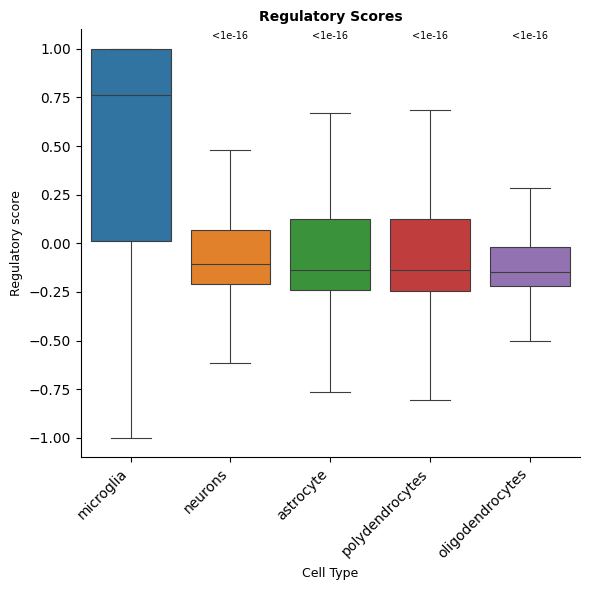

neurons 2577



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



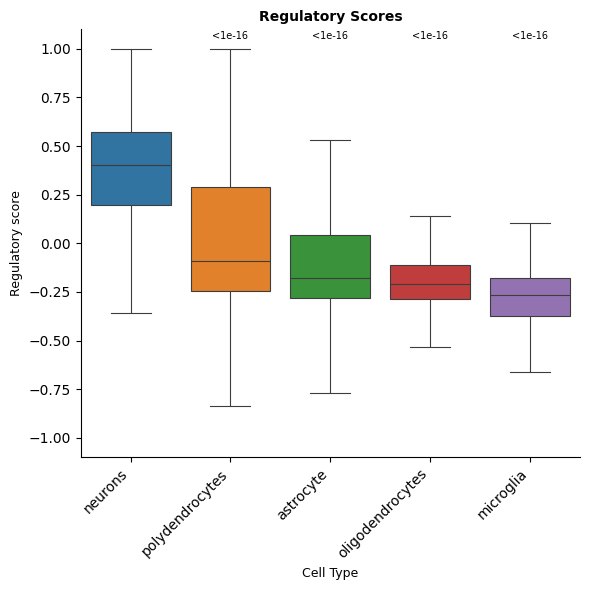

oligodendrocytes 2440



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



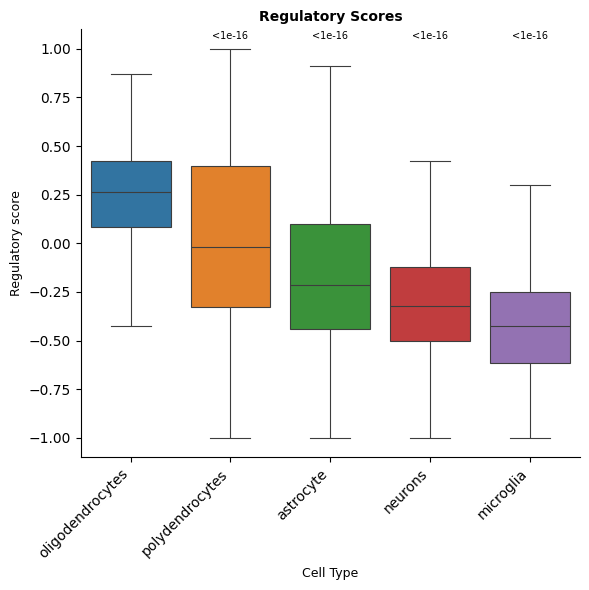

In [34]:
data = {}
for i in range(0, len(edge_names_path_list)):
    edge_base = pd.read_csv(edge_names_path_list[i], header=None, sep='\t', names=['peak', 'gene'])
    edge_base['edge'] = edge_base['peak'] + "_" + edge_base['gene']
    edge_index = np.where(adata_edge.var_names.isin(edge_base['edge']))[0]
    print(celltype[i],len(edge_index))
    data[celltype[i]] = plot_regulatory_scores(res_edge, np.unique(edge_index), cell_type_cpu, unique_celltype)

### AUC 

In [35]:
def calculate_auc_for_cluster(cluster_id, res_edge, edge_index, adata_edge):
    """
    Calculate AUC for a given cluster using precomputed DE results.

    Parameters:
        cluster_id (str or int): Target cluster identifier.
        res_edge (np.ndarray): Feature matrix (cells x features).
        edge_index (array-like): Indices of selected regulatory edges.
        adata_edge (AnnData): AnnData with edge-level DE results (var_names must match res_edge columns).

    Returns:
        float: AUC score.
    """
    # Create binary labels for selected edges
    y_true = np.zeros(res_edge.shape[1])
    y_true[edge_index] = 1

    # Get DE edge names and log fold changes
    edge_names = np.array(adata_edge.uns['rank_genes_groups']['names'][str(cluster_id)])
    logfc = np.array(adata_edge.uns['rank_genes_groups']['logfoldchanges'][str(cluster_id)])

    # Filter out NaNs
    valid = ~np.isnan(logfc)
    edge_names = edge_names[valid]
    logfc = logfc[valid]

    # Get indices of DE edges that exist in adata_edge.var_names
    valid_idx = adata_edge.var_names.get_indexer(edge_names)
    valid_mask = valid_idx != -1
    gene_indices = valid_idx[valid_mask]
    logfc = logfc[valid_mask]

    if len(gene_indices) == 0:
        return np.nan  # No valid edges

    # Normalize logFC
    logfc = (logfc - logfc.mean()) / logfc.std()

    # True labels for selected DE features
    y_filtered = y_true[gene_indices]

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_filtered, logfc)
    return auc(fpr, tpr)


In [36]:
adata_edge.obsm['res_edge_zscore'] = zscore(res_edge, axis=0)
adata_edge.obs['cluster'] = cell_type_cpu.astype(str)

sc.tl.rank_genes_groups(
    adata_edge,
    groupby='cluster',
    reference='rest',
    use_raw=False,
    obsm='res_edge_zscore',
    method='wilcoxon'
)


In [38]:
temp_list_rr = []

# Loop over each cell type and its corresponding index
for i, ct in enumerate(celltype):
    # Load the peak-gene edge file for this cell type
    edge_base = pd.read_csv(edge_names_path_list[i], header=None, sep='\t', names=['peak', 'gene'])
    
    # Create a unique edge identifier by combining peak and gene
    edge_base['edge'] = edge_base['peak'] + "_" + edge_base['gene']

    # Find indices of edges present in adata_edge.var_names and remove duplicates
    edge_index = np.unique(np.where(adata_edge.var_names.isin(edge_base['edge']))[0])

    # Print the number of edges loaded and how many matched in adata_edge
    print(ct, len(edge_base), len(edge_index))

    # Calculate AUC score for the current cell type using the identified edge indices
    auc_score = calculate_auc_for_cluster(ct, res_edge, edge_index, adata_edge)

    # Store the result
    temp_list_rr.append(auc_score)


microglia 1825 1762
neurons 2703 2577
oligodendrocytes 2604 2440


In [39]:
temp_list_rr

[0.7842519643793731, 0.7484616727590053, 0.8092298769570064]

In [40]:
np.mean(temp_list_rr)

0.7806478380317948